# The analysis for journey data

## An analysis for the cycle hire data

We will consider the influence of multiple factors of the physical environment on the number of travels

In [1]:
# load libraries

import os
import csv
import json
import urllib.request
from requests import get

import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.plot

import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import linear_model
import statsmodels.api as sm


In [184]:
# set path
points_path = os.path.join('data', 'cycles', 'points')
points_fn = 'BikePoints.geojson'
points_parquet_fn = 'docking_stations.geoparquet'
journeys_path = os.path.join('data', 'cycles', 'journeys')
journeys_gdf_fn = 'journeys_gdf.geoparquet'
journeys_df_fn = 'journeys_df.parquet'
elevation_path = os.path.join('data', 'elevation', 'london_elevation.tif')
geom_path = os.path.join('data', 'London_geometry')
lsoa_fn = 'LSOA_2011_London_gen_MHW.shp'
msoa_fn = 'MSOA_2011_London_gen_MHW.shp'
cc_fn = 'CentralUltraLowEmissionZone.gpkg'

In [3]:
# load data
journeys_gdf = gpd.read_parquet(os.path.join(journeys_path, journeys_gdf_fn))
journeys_df = gpd.read_parquet(os.path.join(journeys_path, journeys_df_fn))

## Basic analysis of the data

First, looking at the characteristics of the dataset.

In [4]:
# filter by start date
journeys_df = journeys_df[journeys_df['Start date'] >= '2022-12-01'].copy()

<Axes: xlabel='Start date,Start date'>

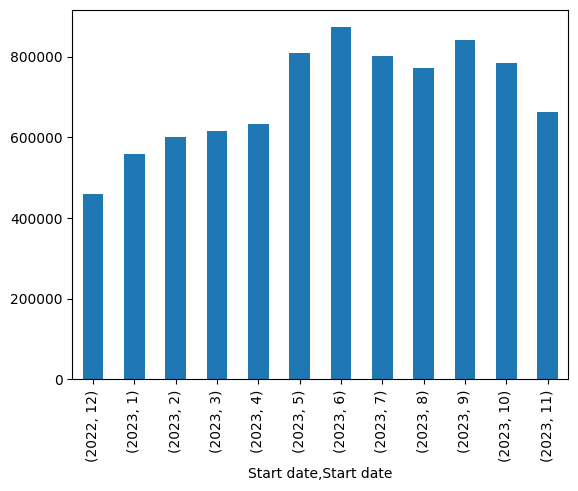

In [5]:
# draw bar chart by month
journeys_df.groupby([journeys_df['Start date'].dt.year, journeys_df['Start date'].dt.month]).Number.count().plot(kind = 'bar')

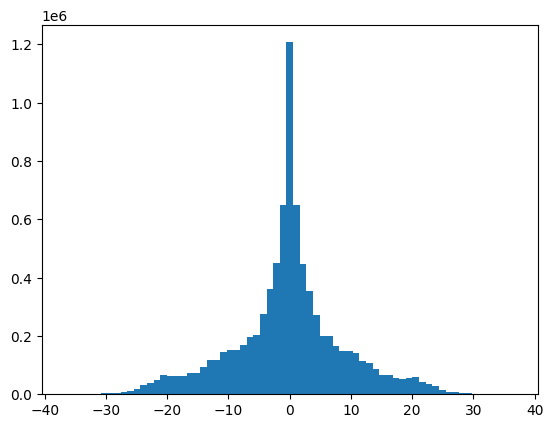

In [6]:
# draw histogram of height distance

# set up plot
fig, ax = plt.subplots(1, 1)

# add histogram
ax.hist(
    journeys_df.height_diff,
    bins = 81
)

# set limits
ax.set_xlim(-40.5, 40.5)

plt.show()


In [7]:
journeys_df[journeys_df['Start station'] != journeys_df['End station']].height_diff.mean()

-0.22877766

In [8]:
scipy.stats.ttest_1samp(journeys_df.height_diff, popmean = 0)

TtestResult(statistic=-69.61426590290411, pvalue=0.0, df=8414630)

### The average height difference

The average of the height difference is -0.22 m. From the one sample T-test, the null hypothesis of average being 0 is rejected, and is statistically significant, concluding that on average the shared cycles are used more downhill than uphill.

(array([1.443276e+06, 2.202603e+06, 1.763172e+06, 1.216677e+06,
        7.556930e+05, 4.513590e+05, 2.545110e+05, 1.445900e+05,
        8.518200e+04, 4.782000e+04, 2.491700e+04, 1.258100e+04,
        6.461000e+03, 2.777000e+03, 1.500000e+03, 9.490000e+02,
        3.900000e+02, 1.320000e+02, 3.600000e+01, 5.000000e+00]),
 array([    0.        ,   858.53878817,  1717.07757635,  2575.61636452,
         3434.15515269,  4292.69394087,  5151.23272904,  6009.77151721,
         6868.31030539,  7726.84909356,  8585.38788173,  9443.92666991,
        10302.46545808, 11161.00424626, 12019.54303443, 12878.0818226 ,
        13736.62061078, 14595.15939895, 15453.69818712, 16312.2369753 ,
        17170.77576347]),
 <BarContainer object of 20 artists>)

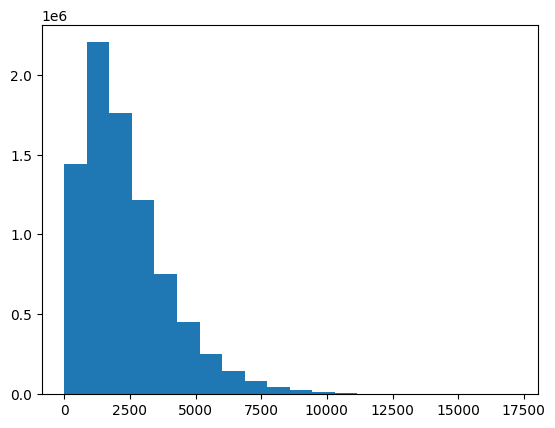

In [9]:
# draw scatter plot


plt.hist(journeys_df['distance'], bins = 20)


In [10]:
# calculate average speed
journeys_df['ave_speed'] = journeys_df['distance'] / journeys_df['Total duration (ms)'] * 1000

## Consider the bike types

The 2 types of bikes existing may make a difference.

In [11]:
# compare the distances
journeys_df.groupby(by = 'Bike model').distance.describe()

C:\Users\Soki\AppData\Local\Temp\ipykernel_10664\2878216079.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  journeys_df.groupby(by = 'Bike model').distance.describe()


,count,mean,std,min,25%,50%,75%,max
Bike model,,,,,,,,
CLASSIC,7808234.0,2279.410865,1656.945009,0.0,1085.307181,1906.495847,3087.379142,17170.775763
PBSC_EBIKE,606397.0,3124.616509,2014.003074,0.0,1651.065859,2757.887126,4181.514950,16682.920172


In [12]:
# compare the height difference
journeys_df.groupby(by = 'Bike model').height_diff.describe()

C:\Users\Soki\AppData\Local\Temp\ipykernel_10664\2032955772.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  journeys_df.groupby(by = 'Bike model').height_diff.describe()


,count,mean,std,min,25%,50%,75%,max
Bike model,,,,,,,,
CLASSIC,7808234.0,-0.231310,9.00606,-43.875999,-3.996001,0.0,3.60825,43.875999
PBSC_EBIKE,606397.0,-0.073767,11.01310,-43.214748,-6.377500,0.0,6.23700,43.779247


In [13]:
journeys_df.groupby(by = ['start_cc_zone', 'end_cc_zone']).height_diff.describe()

count      mean        std        min  \
start_cc_zone end_cc_zone                                              
False         False        3788352.0 -0.173816   7.835636 -43.875999   
              True         1432552.0 -0.037089  10.530090 -43.293499   
True          False        1265977.0 -0.726798  10.431625 -37.391251   
              True         1927750.0 -0.113674   9.589618 -36.318249   

                                25%     50%       75%        max  
start_cc_zone end_cc_zone                                         
False         False       -2.899501  0.0000  2.700500  43.875999  
              True        -5.550250 -0.1775  6.324749  36.418751  
True          False       -7.102500 -0.1495  4.493000  43.117249  
              True        -5.281001  0.0000  5.079500  36.318249

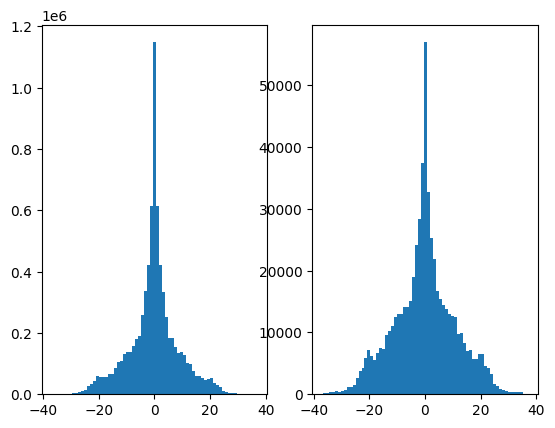

In [14]:
# set up plot
fig, axes = plt.subplots(1, 2)

# add histogram for classic cycles
axes[0].hist(
    journeys_df[journeys_df['Bike model'] == 'CLASSIC'].height_diff,
    bins = 81
)

# add histogram for ebikes
axes[1].hist(
    journeys_df[journeys_df['Bike model'] == 'PBSC_EBIKE'].height_diff,
    bins = 81
)


# set limits
for ax in axes:
    ax.set_xlim(-40.5, 40.5)

plt.show()

In [15]:
# conduct t-test

scipy.stats.ttest_ind(
    journeys_df[journeys_df['Bike model'] == 'CLASSIC'].height_diff,
    journeys_df[journeys_df['Bike model'] == 'PBSC_EBIKE'].height_diff
)

# the small p-value indicates there is significant difference in the distributions of the two types of bikes

TtestResult(statistic=-12.893918258674379, pvalue=4.874543134223036e-38, df=8414629.0)

In [55]:
# OD analysis
od_df = journeys_df.groupby(['start_id', 'end_id', 'Bike model']).Number.count().reset_index()

C:\Users\Soki\AppData\Local\Temp\ipykernel_10664\218624464.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  od_df = journeys_df.groupby(['start_id', 'end_id', 'Bike model']).Number.count().reset_index()


In [17]:
# join with bike points data

# read points data
points_gdf = gpd.read_parquet(os.path.join(points_path, points_parquet_fn)).set_index('id')

# make ports into numeric
points_gdf['ports'] = points_gdf.ports.astype('int')


In [45]:
# join with PTAL grid value

# get file path
ptal_path = os.path.join('data', '2015  PTALs Grid Values')
ptal_fn = '2015  PTALs Grid Values 280515.xlsx'

# read from excel file
# source: London Data Store
# https://data.london.gov.uk/dataset/public-transport-accessibility-levels
ptal_df = pd.read_excel(os.path.join(ptal_path, ptal_fn), sheet_name = 0).drop(columns = 'ID')

# get GeoDataFrame

ptal_gdf = gpd.GeoDataFrame(ptal_df.AI2015, geometry = gpd.points_from_xy(ptal_df.X, ptal_df.Y), crs = 'EPSG:27700')


In [46]:
ptal_gdf

,AI2015,geometry
0,0.0,POINT (530870.000 155930.000)
1,0.0,POINT (530945.000 155898.000)
2,0.0,POINT (531045.000 155898.000)
3,0.0,POINT (531145.000 155898.000)
4,0.0,POINT (531245.000 155898.000)
...,...,...
159446,0.0,POINT (530945.000 200878.000)
159447,0.0,POINT (531045.000 200878.000)
159448,0.0,POINT (531145.000 200878.000)
159449,0.0,POINT (531245.000 200878.000)


In [47]:
points_gdf['ptal_id'] = ptal_gdf.sindex.nearest(points_gdf.geometry, return_all = False)[1]

In [52]:
points_gdf = points_gdf.join(ptal_gdf.AI2015, on = 'ptal_id')

<Axes: >

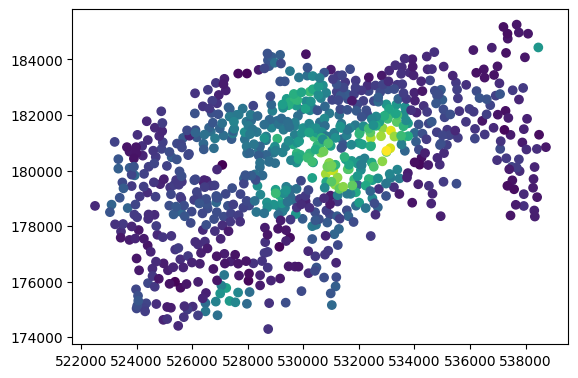

In [53]:
points_gdf.plot(c = points_gdf.AI2015)

In [56]:
# join with points
od_df = od_df.join(points_gdf.add_prefix('start_'), on = 'start_id').join(points_gdf.add_prefix('end_'), on = 'end_id')

In [57]:
# convert number of ports into numeric
numbers = ['start_ports', 'end_ports']
for c in numbers:
    od_df[c] = od_df[c].astype('int')

In [58]:
# define start and end points as GeoSeries
start_geoseries = gpd.GeoSeries(od_df.start_geometry, crs = 'EPSG:27700')
end_geoseries = gpd.GeoSeries(od_df.end_geometry, crs = 'EPSG:27700')

# calculate distance and store in df
od_df['distance'] = start_geoseries.distance(end_geoseries, align = False)

# calculate height difference and store in df
od_df['height_diff'] = od_df.end_height - od_df.start_height

In [69]:
od_df

,start_id,end_id,Bike model,Number,start_name,start_ports,start_location,start_zone,start_height,start_LSOA11CD,...,end_LSOA11CD,end_LSOA11NM,end_MSOA11CD,end_MSOA11NM,end_cc_zone,end_geometry,end_ptal_id,end_AI2015,distance,height_diff
0,000959,000959,CLASSIC,204,"Milroy Walk, South Bank",30,Milroy Walk,South Bank,4.973,E01003934,...,E01003934,Southwark 002C,E02000808,Southwark 002,True,POINT (531525.563 180401.245),79829,83.497777,0.000000,0.00000
1,000959,000959,PBSC_EBIKE,15,"Milroy Walk, South Bank",30,Milroy Walk,South Bank,4.973,E01003934,...,E01003934,Southwark 002C,E02000808,Southwark 002,True,POINT (531525.563 180401.245),79829,83.497777,0.000000,0.00000
2,000959,000960,CLASSIC,309,"Milroy Walk, South Bank",30,Milroy Walk,South Bank,4.973,E01003934,...,E01003929,Southwark 002B,E02000808,Southwark 002,True,POINT (532536.883 180136.298),78840,109.437704,1045.449467,-0.59625
3,000959,000960,PBSC_EBIKE,4,"Milroy Walk, South Bank",30,Milroy Walk,South Bank,4.973,E01003934,...,E01003929,Southwark 002B,E02000808,Southwark 002,True,POINT (532536.883 180136.298),78840,109.437704,1045.449467,-0.59625
4,000959,000961,CLASSIC,45,"Milroy Walk, South Bank",30,Milroy Walk,South Bank,4.973,E01003934,...,E01003927,Southwark 002A,E02000808,Southwark 002,True,POINT (532072.956 180019.734),78339,73.774954,667.225341,-1.83425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279995,300253,300250,PBSC_EBIKE,0,"Bermondsey Station, Bermondsey",30,Bermondsey Station,Bermondsey,2.634,E01004023,...,E01032740,City of London 001G,E02000001,City of London 001,True,POINT (531370.132 180813.069),82322,38.778208,3432.471853,1.83775
1279996,300253,300252,CLASSIC,163,"Bermondsey Station, Bermondsey",30,Bermondsey Station,Bermondsey,2.634,E01004023,...,E01004033,Southwark 007C,E02000813,Southwark 007,False,POINT (535513.214 179526.162),75945,35.843454,995.575988,2.96175
1279997,300253,300252,PBSC_EBIKE,5,"Bermondsey Station, Bermondsey",30,Bermondsey Station,Bermondsey,2.634,E01004023,...,E01004033,Southwark 007C,E02000813,Southwark 007,False,POINT (535513.214 179526.162),75945,35.843454,995.575988,2.96175
1279998,300253,300253,CLASSIC,334,"Bermondsey Station, Bermondsey",30,Bermondsey Station,Bermondsey,2.634,E01004023,...,E01004023,Southwark 004D,E02000810,Southwark 004,False,POINT (534520.526 179450.393),75450,21.592552,0.000000,0.00000


In [259]:
# group by MSOA
msoa_od = od_df[od_df['Bike model'] == 'CLASSIC'].groupby(['start_MSOA11CD', 'end_MSOA11CD']).agg(
    {
        'Number': 'sum',
        'distance': 'mean',
        'height_diff': 'mean',
    }
).reset_index()

# summarise the point information by MSOA as well
points_msoa = points_gdf.groupby('MSOA11CD').agg(
    {
        'name': 'count',
        'ports': 'sum',
        'height': 'mean',
        'AI2015': 'mean'
    }
).rename(columns = {'name': 'stations', 'ports': 'total_ports', 'height': 'mean_height'})



In [260]:
# join with summarised point information
msoa_od = msoa_od.join(points_msoa.add_prefix('start_'), on = 'start_MSOA11CD').join(points_msoa.add_prefix('end_'), on = 'end_MSOA11CD')

# calculate journeys per station
msoa_od['number_per_stn'] = msoa_od.Number / msoa_od.start_stations / msoa_od.end_stations

In [261]:
# join population data
# year: 2020
# source: https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/middlesuperoutputareamidyearpopulationestimates

msoa_pop = pd.read_csv(os.path.join('data', 'msoa_population.csv'), skiprows = 4)
msoa_pop = msoa_pop[['MSOA Code', 'All Ages']].copy().rename(columns = {'All Ages': 'population'}).set_index('MSOA Code')

# change population into integer
msoa_pop['population'] = msoa_pop['population'].str.replace(',','').astype('int')

In [262]:
# get population density

# load geometry
msoa_geom = gpd.read_file(os.path.join(geom_path, msoa_fn)).set_index('MSOA11CD')

# calculate area in km2
msoa_geom['msoa_area'] = msoa_geom.area / 1000000

# join with population
msoa_pop = msoa_pop.join(msoa_geom['msoa_area'], how = 'inner')

# calculate density
msoa_pop['pop_density'] = msoa_pop.population / msoa_pop.msoa_area


In [263]:
msoa_pop

,population,msoa_area,pop_density
E02000001,10938,2.905399,3764.714879
E02000002,7726,2.165634,3567.546886
E02000003,11246,2.143565,5246.400275
E02000004,6646,2.490215,2668.845385
E02000005,10540,1.186180,8885.667141
...,...,...,...
E02000979,11046,1.397778,7902.541507
E02000980,11123,0.446787,24895.546729
E02000981,10712,0.363726,29450.711401
E02000982,9390,0.656821,14296.128890


In [264]:
msoa_od = msoa_od.join(msoa_pop.add_prefix('start_'), on = 'start_MSOA11CD').join(msoa_pop.add_prefix('end_'), on = 'end_MSOA11CD')

<Axes: xlabel='Start date'>

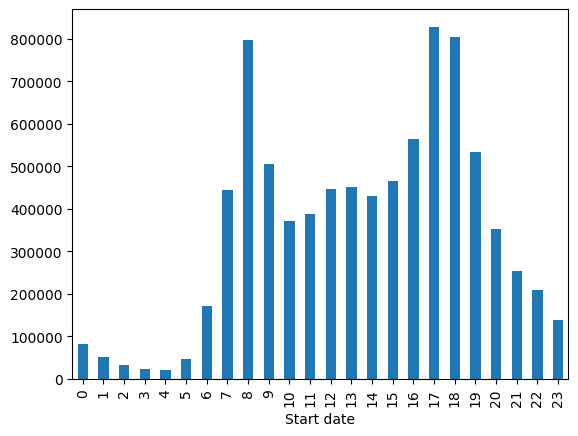

In [265]:
journeys_df.groupby(journeys_df['Start date'].dt.hour).Number.count().plot(kind = 'bar')

In [266]:
# extract one origin or destination to begin
# chose the City of London as starting point for analysis

target_msoa = 'E02000001'

city_df = msoa_od[((msoa_od.start_MSOA11CD == target_msoa) | (msoa_od.end_MSOA11CD == target_msoa)) & (msoa_od.start_MSOA11CD != msoa_od.end_MSOA11CD)].copy()

In [267]:
# create columns containing data for the 'other' area

#city_df['other_stations'] = []
#city_df['other_total_ports'] = []
#city_df['other_mean_height'] = []
#city_df['is_outbound'] = []

for idx, row in city_df.iterrows():
    if(row['start_MSOA11CD'] == target_msoa):
        city_df.loc[idx, 'other_stations'] = row['end_stations']
        city_df.loc[idx, 'other_total_ports'] = row['end_total_ports']
        city_df.loc[idx, 'other_mean_height'] = row['end_mean_height']
        city_df.loc[idx, 'other_AI2015'] = row['end_AI2015']
        city_df.loc[idx, 'other_pop'] = row['end_population']
        city_df.loc[idx, 'is_outbound'] = 0
    else:
        city_df.loc[idx, 'other_stations'] = row['start_stations']
        city_df.loc[idx, 'other_total_ports'] = row['start_total_ports']
        city_df.loc[idx, 'other_mean_height'] = row['start_mean_height']
        city_df.loc[idx, 'other_AI2015'] = row['start_AI2015']   
        city_df.loc[idx, 'other_pop'] = row['start_population']     
        city_df.loc[idx, 'is_outbound'] = 1      

city_df


,start_MSOA11CD,end_MSOA11CD,Number,distance,height_diff,start_stations,start_total_ports,start_mean_height,start_AI2015,end_stations,...,start_pop_density,end_population,end_msoa_area,end_pop_density,other_stations,other_total_ports,other_mean_height,other_AI2015,other_pop,is_outbound
1,E02000001,E02000180,502,3715.141455,18.149588,38,1008,13.108163,90.035485,1,...,3764.714879,10445,0.485621,21508.551292,1.0,24.0,31.257751,7.170528,10445.0,0.0
2,E02000001,E02000183,407,4595.559996,17.980461,38,1008,13.108163,90.035485,2,...,3764.714879,9293,0.769140,12082.328249,2.0,53.0,31.088625,35.816240,9293.0,0.0
3,E02000001,E02000184,1468,4105.302768,12.400024,38,1008,13.108163,90.035485,4,...,3764.714879,11278,0.666096,16931.485809,4.0,156.0,25.508188,49.319044,11278.0,0.0
4,E02000001,E02000186,1064,4093.716044,15.992430,38,1008,13.108163,90.035485,8,...,3764.714879,8753,1.001597,8739.043245,8.0,244.0,29.100594,43.550999,8753.0,0.0
5,E02000001,E02000187,2815,3232.230471,8.932254,38,1008,13.108163,90.035485,6,...,3764.714879,12144,0.964298,12593.618293,6.0,166.0,22.040419,63.645549,12144.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24800,E02000983,E02000001,2252,4315.636908,8.164514,5,133,4.943650,33.439148,38,...,27289.993332,10938,2.905399,3764.714879,5.0,133.0,4.943650,33.439148,10217.0,1.0
24960,E02006801,E02000001,52297,2123.247952,8.557644,18,468,4.550519,113.616513,38,...,10036.628719,10938,2.905399,3764.714879,18.0,468.0,4.550519,113.616513,11429.0,1.0
25120,E02006802,E02000001,8526,2106.171447,9.716639,10,342,3.391525,90.549238,38,...,12302.233867,10938,2.905399,3764.714879,10.0,342.0,3.391525,90.549238,8503.0,1.0
25280,E02006853,E02000001,1496,5441.921509,9.689497,3,73,3.418667,6.112977,38,...,23076.084379,10938,2.905399,3764.714879,3.0,73.0,3.418667,6.112977,11559.0,1.0


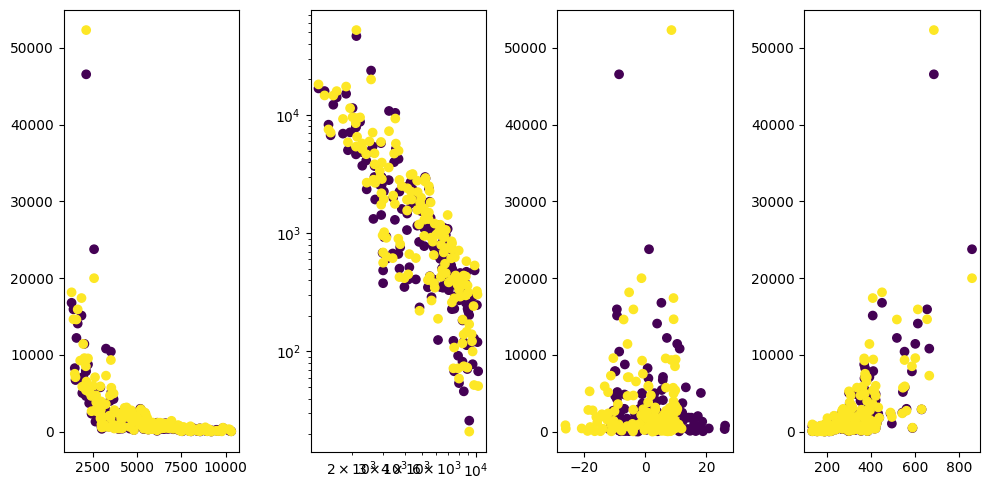

In [268]:
# make plot
fig, axes = plt.subplots(1,4, figsize = (10, 5))

# distance
axes[0].scatter(
    x = city_df.distance,
    y = city_df.Number,
    c = city_df.is_outbound
)

axes[1].scatter(
    x = city_df.distance,
    y = city_df.Number,
    c = city_df.is_outbound
)


# take a double log scale for the second one
axes[1].set_xscale('log')
axes[1].set_yscale('log')

# height difference
axes[2].scatter(
    x = city_df.height_diff,
    y = city_df.Number,
    c = city_df.is_outbound
)

# total ports
axes[3].scatter(
    x = np.sqrt(city_df.start_total_ports * city_df.end_total_ports),
    y = city_df.Number,
    c = city_df.is_outbound
)

plt.tight_layout()
plt.show()

In [269]:
# check the power law behind distance

# get log for distance and trips
city_df['distance_log'] = np.log(city_df.distance)
city_df['number_log'] = np.log(city_df.Number)


log_model = sm.OLS(endog = city_df['number_log'], exog = sm.add_constant(city_df['distance_log'])).fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             number_log   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     783.4
Date:                Thu, 11 Jan 2024   Prob (F-statistic):           1.49e-87
Time:                        02:26:36   Log-Likelihood:                -365.62
No. Observations:                 318   AIC:                             735.2
Df Residuals:                     316   BIC:                             742.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           26.4892      0.700     37.841      0.000      25.112      27.866
distance_log    -2.3132      0.083    -27.989      0.000      -2.476      -2.151
==============================================================================
Omnibus:                        7.908   Durbin-Watson:                   1.419
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                7.969
Skew:                          -0.387   Prob(JB):                       0.0186
Kurtosis:                       3.045   Cond. No.                         140.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [270]:
# calculate inverse squared value
city_df['distance_inv_sq'] = city_df.distance.astype('float') ** (-2)


Text(0.5, 1.0, 'Correlation Matrix')

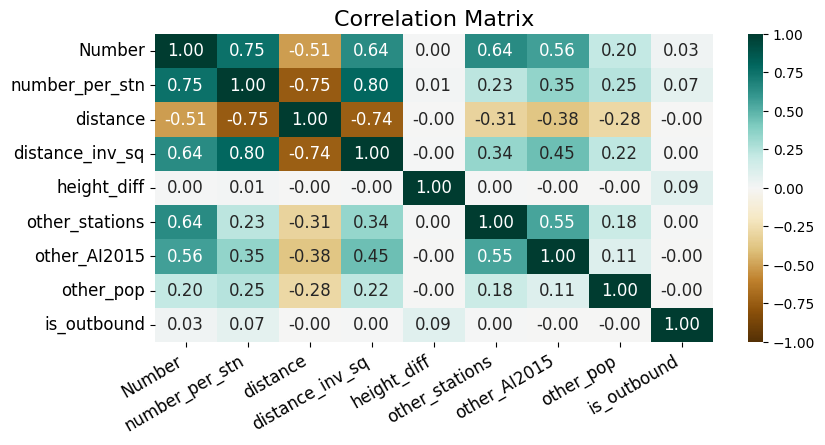

In [271]:
# check multi-colinearity
df = city_df[['Number', 'number_per_stn', 'distance', 'distance_inv_sq', 'height_diff', 'other_stations', 'other_AI2015', 'other_pop', 'is_outbound']].copy()
plt.figure(figsize = (9, 4))
heatmap = sns.heatmap(df.corr(), annot = True, vmin = -1, vmax = 1, cmap = 'BrBG', fmt = '.2f', annot_kws = {'fontsize': 12})
# plt.rcParams["axes.grid"] = False
# f = plt.figure(figsize=(10, 8))
# plt.matshow(df.corr(), fignum=f.number, cmap = 'Blues')
plt.xticks(fontsize = 12, rotation=30, ha = 'right') # rotation of xticks
plt.yticks(fontsize = 12)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [272]:
# run linear regression

# set dependent variables
x = city_df[['distance_inv_sq', 'height_diff', 'other_AI2015', 'other_pop', 'is_outbound']]
y = city_df.number_per_stn

model1 = sm.OLS(endog = y, exog = sm.add_constant(x)).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         number_per_stn   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     113.5
Date:                Thu, 11 Jan 2024   Prob (F-statistic):           4.73e-68
Time:                        02:26:36   Log-Likelihood:                -1104.7
No. Observations:                 318   AIC:                             2221.
Df Residuals:                     312   BIC:                             2244.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3461      1.757      0.197      0.844      -3.111       3.803
distance_inv_sq  1.018e+08   4.99e+06     20.384      0.000     9.2e+07    1.12e+08
height_diff         0.0027      0.049      0.054      0.957      -0.094       0.100
other_AI2015       -0.0060      0.025     -0.243      0.808      -0.055       0.043
other_pop           0.0003      0.000      2.049      0.041    1.29e-05       0.001
is_outbound         1.9497      0.888      2.196      0.029       0.203       3.696
==============================================================================
Omnibus:                      163.165   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1586.959
Skew:                           1.886   Prob(JB):                         0.00
Kurtosis:                      13.273   Cond. No.                     1.16e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.49e-12. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [273]:
# check if these parameters can be applied for the rest of the city as well



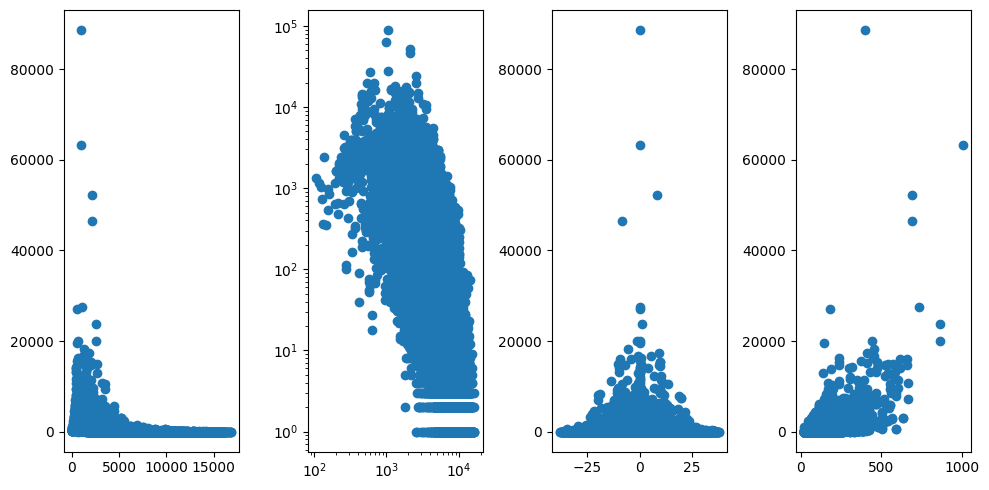

In [274]:
# make plot

fig, axes = plt.subplots(1,4, figsize = (10, 5))

# distance
axes[0].scatter(
    x = msoa_od.distance,
    y = msoa_od.Number,
#    c = msoa_od.is_outbound
)

axes[1].scatter(
    x = msoa_od.distance,
    y = msoa_od.Number,
#    c = msoa_od.is_outbound
)


# take a double log scale for the second one
axes[1].set_xscale('log')
axes[1].set_yscale('log')

# height difference
axes[2].scatter(
    x = msoa_od.height_diff,
    y = msoa_od.Number,
#    c = msoa_od.is_outbound
)

# total ports
axes[3].scatter(
    x = np.sqrt(msoa_od.start_total_ports * msoa_od.end_total_ports),
    y = msoa_od.Number,
#    c = msoa_od.is_outbound
)

plt.tight_layout()
plt.show()

In [275]:
msoa_od_diff = msoa_od[msoa_od.start_MSOA11CD != msoa_od.end_MSOA11CD].copy()

Text(0.5, 1.0, 'Correlation Matrix')

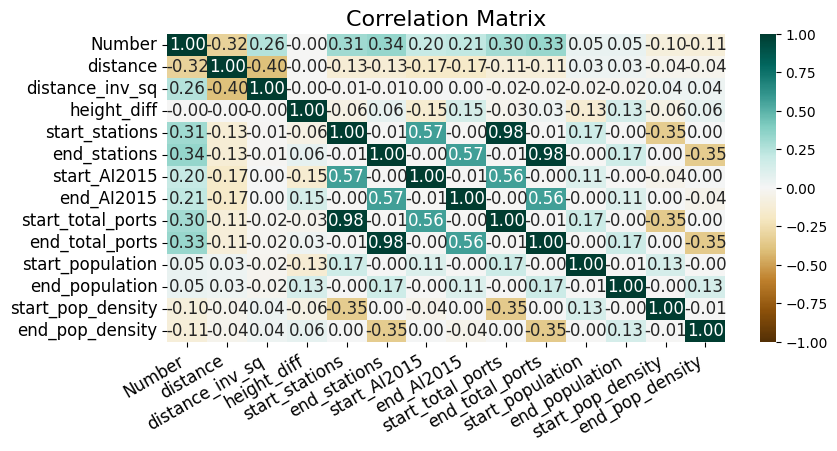

In [278]:
# calculate inverse squared value
msoa_od_diff['distance_inv_sq'] = msoa_od_diff.distance.astype('float') ** (-2) * 1000000

# check multi-colinearity
df2 = msoa_od_diff[['Number', 'distance', 'distance_inv_sq', 'height_diff', 'start_stations', 'end_stations', 'start_AI2015', 'end_AI2015', 'start_total_ports', 'end_total_ports', 'start_population', 'end_population', 'start_pop_density', 'end_pop_density']].copy()
plt.figure(figsize = (9, 4))
heatmap = sns.heatmap(df2.corr(), annot = True, vmin = -1, vmax = 1, cmap = 'BrBG', fmt = '.2f', annot_kws = {'fontsize': 12})
# plt.rcParams["axes.grid"] = False
# f = plt.figure(figsize=(10, 8))
# plt.matshow(df.corr(), fignum=f.number, cmap = 'Blues')
plt.xticks(fontsize = 12, rotation=30, ha = 'right') # rotation of xticks
plt.yticks(fontsize = 12)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [280]:
# run linear regression

# set dependent variables
x = df2[['distance_inv_sq', 'height_diff', 'start_stations', 'end_stations', 'start_AI2015', 'end_AI2015']]
y = df2.Number

model2 = sm.OLS(endog = y, exog = sm.add_constant(x)).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Number   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     1677.
Date:                Thu, 11 Jan 2024   Prob (F-statistic):               0.00
Time:                        02:31:30   Log-Likelihood:            -2.0702e+05
No. Observations:               25440   AIC:                         4.141e+05
Df Residuals:                   25433   BIC:                         4.141e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -540.1415     13.278    -40.680      0.000    -566.167    -514.116
distance_inv_sq   816.3025     16.324     50.006      0.000     784.307     848.298
height_diff        -0.5025      0.419     -1.200      0.230      -1.323       0.318
start_stations     62.4874      1.337     46.747      0.000      59.867      65.107
end_stations       68.5128      1.337     51.255      0.000      65.893      71.133
start_AI2015        1.1279      0.312      3.620      0.000       0.517       1.739
end_AI2015          1.1351      0.312      3.644      0.000       0.525       1.746
==============================================================================
Omnibus:                    54456.120   Durbin-Watson:                   1.589
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        737036972.850
Skew:                          18.514   Prob(JB):                         0.00
Kurtosis:                     836.035   Cond. No.                         166.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [282]:
# go back to the original OD pairs
od_df_merged = od_df.join(msoa_pop.add_prefix('start_'), on = 'start_MSOA11CD').join(msoa_pop.add_prefix('end_'), on = 'end_MSOA11CD')

In [284]:
# remove round trips
od_df_merged = od_df_merged[od_df_merged.start_id != od_df_merged.end_id].copy()

In [287]:
# calculate inverted squared distance
od_df_merged['distance_inv_sq'] = od_df_merged.distance ** (-2) * 1000000

In [288]:
od_df_merged.columns

Index(['start_id', 'end_id', 'Bike model', 'Number', 'start_name',
       'start_ports', 'start_location', 'start_zone', 'start_height',
       'start_LSOA11CD', 'start_LSOA11NM', 'start_MSOA11CD', 'start_MSOA11NM',
       'start_cc_zone', 'start_geometry', 'start_ptal_id', 'start_AI2015',
       'end_name', 'end_ports', 'end_location', 'end_zone', 'end_height',
       'end_LSOA11CD', 'end_LSOA11NM', 'end_MSOA11CD', 'end_MSOA11NM',
       'end_cc_zone', 'end_geometry', 'end_ptal_id', 'end_AI2015', 'distance',
       'height_diff', 'start_population', 'start_msoa_area',
       'start_pop_density', 'end_population', 'end_msoa_area',
       'end_pop_density', 'distance_inv_sq'],
      dtype='object')

In [299]:
columns = ['Number', 'distance', 'distance_inv_sq', 'start_pop_density', 'end_pop_density', 'start_AI2015', 'end_AI2015', 'start_ports', 'end_ports', 'height_diff']

od_df_reg = od_df_merged[columns].copy()

Text(0.5, 1.0, 'Correlation Matrix')

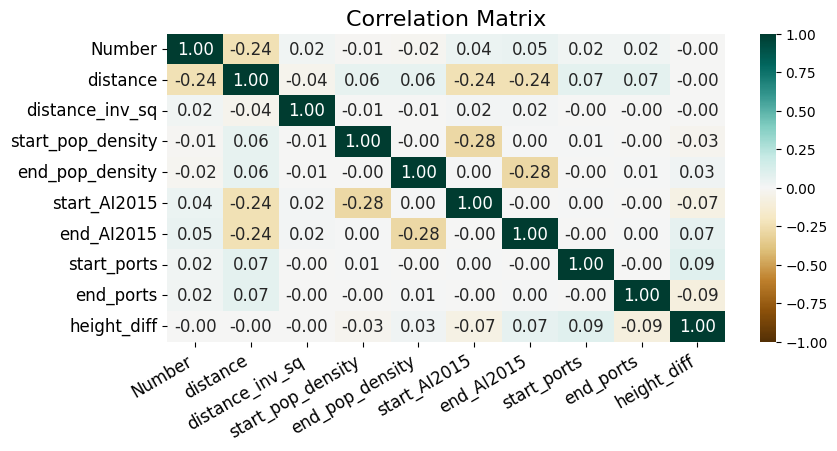

In [300]:
# check multi-colinearity
plt.figure(figsize = (9, 4))
heatmap = sns.heatmap(od_df_reg.corr(), annot = True, vmin = -1, vmax = 1, cmap = 'BrBG', fmt = '.2f', annot_kws = {'fontsize': 12})
# plt.rcParams["axes.grid"] = False
# f = plt.figure(figsize=(10, 8))
# plt.matshow(df.corr(), fignum=f.number, cmap = 'Blues')
plt.xticks(fontsize = 12, rotation=30, ha = 'right') # rotation of xticks
plt.yticks(fontsize = 12)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [301]:
# run linear regression

# set dependent variables
x = od_df_reg.drop(columns = 'Number')
y = od_df_reg.Number

model3 = sm.OLS(endog = y, exog = sm.add_constant(x)).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Number   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     8993.
Date:                Thu, 11 Jan 2024   Prob (F-statistic):               0.00
Time:                        02:46:37   Log-Likelihood:            -5.9679e+06
No. Observations:             1278400   AIC:                         1.194e+07
Df Residuals:                 1278390   BIC:                         1.194e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                13.8812      0.151     91.727      0.000      13.585      14.178
distance             -0.0022   7.98e-06   -271.470      0.000      -0.002      -0.002
distance_inv_sq       0.0243      0.002     11.909      0.000       0.020       0.028
start_pop_density -8.789e-06   3.94e-06     -2.231      0.026   -1.65e-05   -1.07e-06
end_pop_density   -4.447e-05   3.94e-06    -11.288      0.000   -5.22e-05   -3.68e-05
start_AI2015         -0.0185      0.001    -23.126      0.000      -0.020      -0.017
end_AI2015           -0.0116      0.001    -14.450      0.000      -0.013      -0.010
start_ports           0.1188      0.003     45.443      0.000       0.114       0.124
end_ports             0.1217      0.003     46.538      0.000       0.117       0.127
height_diff          -0.0090      0.002     -5.076      0.000      -0.013      -0.006
==============================================================================
Omnibus:                  3036209.852   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     111198472155.218
Skew:                          23.667   Prob(JB):                         0.00
Kurtosis:                    1447.071   Cond. No.                     1.40e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""